In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.font_manager as fm

In [19]:
#load files
df_qinghe_esf= pd.read_excel('data/qinghe_esf.xlsx')
df_qinghe_zu=pd.read_excel('data/qinghe_zu.xlsx',names=['square','rent'],header=0)
df_xierqi_esf= pd.read_excel('data/xierqi_esf.xlsx',names=['square','total','unit'],header=0)
df_xierqi_zu= pd.read_excel('data/xierqi_zu.xlsx',names=['square','rent'],header=0)
df_xisanqi_esf= pd.read_excel('data/xisanqi_esf.xlsx',names=['square','total','unit'],header=0)
df_xisanqi_zu= pd.read_excel('data/xisanqi_zu.xlsx',names=['square','rent'],header=0)
df_shangdi_esf = pd.read_excel('data/df_esf_shangdi.xlsx',names=['location','community','square','total','unit'],header=0)
df_shangdi_zu = pd.read_excel('data/df_rent_shangdi.xlsx',names=['location','community','square','rent'],header=0)

In [11]:
df_qinghe_esf.insert(1, 'location', '清河')
df_qinghe_zu.insert(1, 'location', '清河')
df_xierqi_esf.insert(1, 'location', '西二旗')
df_xierqi_zu.insert(1, 'location', '西二旗')
df_xisanqi_esf.insert(1, 'location', '西三旗')
df_xisanqi_zu.insert(1, 'location', '西三旗')
del df_shangdi_esf['community']
del df_shangdi_zu['community']
df_shangdi_esf['total']=df_shangdi_esf['total']/10000

In [12]:
#Convert all data formats to floating point numbers
cols_to_fix = ['square', 'total', 'unit']

for col in cols_to_fix:
    df_qinghe_esf[col] = df_qinghe_esf[col].astype(float)
    df_xierqi_esf[col] = df_xierqi_esf[col].astype(float)
    df_xisanqi_esf[col] = df_xisanqi_esf[col].astype(float)
    df_shangdi_esf[col] = df_shangdi_esf[col].astype(float)

In [13]:
#Convert all data formats to floating point numbers
cols_to_fix = ['square', 'rent']

for col in cols_to_fix:
    df_qinghe_zu[col] = df_qinghe_zu[col].astype(float)
    df_xierqi_zu[col] = df_xierqi_zu[col].astype(float)
    df_xisanqi_zu[col] = df_xisanqi_zu[col].astype(float)
    df_shangdi_zu[col] = df_shangdi_zu[col].astype(float)

In [14]:
#Merge the information of second-hand houses together
df_esf = (
df_qinghe_esf.merge(df_xierqi_esf, on=['location','square','total','unit'], how='outer')
.merge(df_xisanqi_esf, on=['location','square','total','unit'], how='outer')
.merge(df_shangdi_esf, on=['location','square','total','unit'], how='outer')
)

In [15]:
#Merge the information of renting houses together
df_zu = (
df_qinghe_zu.merge(df_xierqi_zu, on=['location','square','rent'], how='outer')
.merge(df_xisanqi_zu, on=['location','square','rent'], how='outer')
.merge(df_shangdi_zu, on=['location','square','rent'], how='outer')
)

In [16]:
# original second hand house data description by block
esf_description_by_block = df_esf.groupby('location')[['square', 'total', 'unit']].describe()
print("data description for all blocks")
print(esf_description_by_block)

data description for all blocks
          square                                                         \
           count        mean        std    min      25%     50%     75%   
location                                                                  
上地        1200.0  114.519133  44.086540  36.69  85.5000  111.57  144.45   
清河        1200.0  158.592917  82.843804  40.23  93.4325  143.80  201.64   
西三旗       1200.0  108.676017  56.849491  37.91  73.3225   89.76  131.28   
西二旗        704.0  120.160611  59.048629  36.32  82.8300  103.66  142.51   

                   total               ...                    unit  \
             max   count         mean  ...     75%     max   count   
location                               ...                           
上地        314.71  1200.0  1007.516583  ...  1200.0  2980.0  1200.0   
清河        562.00  1200.0  1496.898333  ...  2050.0  4300.0  1200.0   
西三旗       638.28  1200.0   667.599583  ...   785.0  4050.0  1200.0   
西二旗       371.03   704

In [21]:
# original rent house data description by block
zu_description_by_block = df_zu.groupby('location')[['square', 'rent']].describe()
print("data description for all blocks")
print(zu_description_by_block)

data description for all blocks
          square                                                         rent  \
           count       mean        std  min   25%   50%    75%    max   count   
location                                                                        
上地         957.0  84.791014  44.776154  6.0  57.0  85.0  114.0  314.0   957.0   
清河        1200.0  80.440000  51.960751  6.0  52.0  70.0   99.0  428.0  1200.0   
西三旗       1100.0  86.133636  65.329120  6.0  51.0  77.0   90.0  346.0  1100.0   
西二旗        424.0  99.775943  68.357524  8.0  60.0  83.0  137.0  305.0   424.0   

                                                                       \
                  mean           std     min     25%     50%      75%   
location                                                                
上地         8396.042842   4014.942343  1000.0  5900.0  7500.0  11000.0   
清河        11983.403333  51572.665759  1000.0  5200.0  6500.0   8800.0   
西三旗        7349.247273   8252.88555

In [22]:
#remove outliners for each block
def remove_outliers_iqr(df,blocks,columns):
    cleaned_blocks = []
    outlier_stats = {}
    
    for block in blocks:
        block_data = df[df['location']==block].copy()
        original_count = len(block_data)
        outlier_stats[block] = {}
        
        for column in columns:
            Q1 = block_data[column].quantile(0.25)
            Q3 = block_data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            before = len(block_data)
            block_data = block_data[
                (block_data[column] >= lower_bound) & 
                (block_data[column] <= upper_bound)
            ]
            after = len(block_data)
            outlier_stats[block][column] = before - after
        cleaned_blocks.append(block_data)
    return pd.concat(cleaned_blocks, ignore_index=True),outlier_stats


In [23]:
df_cleaned_esf,outlier_stats_esf=remove_outliers_iqr(df_esf,['清河','西二旗','西三旗','上地'],['square','total','unit'])
df_cleaned_zu,outlier_stats_zu=remove_outliers_iqr(df_zu,['清河','西二旗','西三旗','上地'],['square','rent'])

In [24]:
# cleaned esf data description by block
esf_cleaned_description_by_block = df_cleaned_esf.groupby('location')[['square', 'total', 'unit']].describe()
print("second-hand house data description after cleaning for all blocks")
print(esf_cleaned_description_by_block)

second-hand house data description after cleaning for all blocks
          square                                                          \
           count        mean        std    min     25%     50%       75%   
location                                                                   
上地        1117.0  111.778371  37.340794  36.69  86.590  111.57  141.2200   
清河        1156.0  149.516808  69.053199  40.23  91.185  142.00  193.8875   
西三旗       1057.0   94.017067  31.933433  37.91  70.100   88.98  111.2600   
西二旗        645.0  106.077969  36.468386  36.32  80.760   98.69  130.1100   

                   total               ...                    unit  \
             max   count         mean  ...     75%     max   count   
location                               ...                           
上地        213.16  1117.0   947.853894  ...  1150.0  1720.0  1117.0   
清河        315.50  1156.0  1442.982699  ...  1980.0  3390.0  1156.0   
西三旗       205.19  1057.0   526.903974  ...   655.0  

In [25]:
# check outliers for second-hand house data
outlier_stats_esf

{'清河': {'square': 32, 'total': 12, 'unit': 0},
 '西二旗': {'square': 49, 'total': 10, 'unit': 0},
 '西三旗': {'square': 62, 'total': 72, 'unit': 9},
 '上地': {'square': 11, 'total': 40, 'unit': 32}}

In [26]:
# cleaned rent data description by block
zu_cleaned_description_by_block = df_cleaned_zu.groupby('location')[['square', 'rent']].describe()
print("rent house data description after cleaning for all blocks")
print(zu_cleaned_description_by_block)

rent house data description after cleaning for all blocks
          square                                                         rent  \
           count       mean        std  min   25%   50%    75%    max   count   
location                                                                        
上地         917.0  80.336968  36.945978  6.0  53.0  80.0  111.0  188.0   917.0   
清河        1036.0  66.083977  30.464864  6.0  48.0  64.0   85.0  162.0  1036.0   
西三旗        908.0  67.281938  28.643261  8.0  51.0  70.0   89.0  140.0   908.0   
西二旗        381.0  81.314961  41.839612  8.0  58.0  71.0  107.0  187.0   381.0   

                                                                              
                 mean          std     min     25%     50%      75%      max  
location                                                                      
上地        7894.888768  3226.768923  1000.0  5830.0  7500.0  10500.0  17000.0  
清河        6256.451737  2401.723967  1000.0  5000.0  6000.0

In [27]:
# check outliers for renting house data
outlier_stats_zu

{'清河': {'square': 58, 'rent': 106},
 '西二旗': {'square': 30, 'rent': 13},
 '西三旗': {'square': 113, 'rent': 79},
 '上地': {'square': 13, 'rent': 27}}

In [28]:
#calculate medianp price rent ratio
#calculate'rent_per_m2' and remove the new outliers
df_cleaned_zu['rent_per_m2'] = df_cleaned_zu['rent'] / df_cleaned_zu['square']
df_cleaned_zu,outlier_stats_zu2=remove_outliers_iqr(df_cleaned_zu,['清河','西二旗','西三旗','上地'],['rent_per_m2'])

In [29]:
zu_cleaned_description_by_block2 = df_cleaned_zu.groupby('location')[['square', 'rent']].describe()
print("rent house data description after cleaning for all blocks")
print(zu_cleaned_description_by_block2)

rent house data description after cleaning for all blocks
         square                                                         rent  \
          count       mean        std   min   25%   50%    75%    max  count   
location                                                                       
上地        888.0  82.040541  36.019075  10.0  57.0  84.0  113.0  188.0  888.0   
清河        950.0  70.184211  27.533498  10.0  54.0  67.0   87.0  162.0  950.0   
西三旗       858.0  70.257576  26.399588  15.0  54.0  73.0   89.0  140.0  858.0   
西二旗       332.0  89.674699  37.064852  13.0  66.0  83.0  120.0  187.0  332.0   

                                                                               
                 mean          std     min      25%     50%      75%      max  
location                                                                       
上地        8034.778153  3113.864316  1000.0  5900.00  7500.0  10500.0  17000.0  
清河        6564.418947  2204.659243  1000.0  5250.75  6300.0  

In [30]:
# check outliers for renting house data after calculation
outlier_stats_zu2

{'清河': {'rent_per_m2': 86},
 '西二旗': {'rent_per_m2': 49},
 '西三旗': {'rent_per_m2': 50},
 '上地': {'rent_per_m2': 29}}

In [31]:
# Calculate the median house price and median rent for each block
esf_median_by_block = df_cleaned_esf.groupby('location')['unit'].median()
zu_median_by_block = df_cleaned_zu.groupby('location')['rent_per_m2'].median()

# Keep only the blocks that exist in both datasets
common_blocks = esf_median_by_block.index.intersection(zu_median_by_block.index)
esf_common = esf_median_by_block[common_blocks]
zu_common = zu_median_by_block[common_blocks]

# Calculate the median rent-to-price ratio
price_rent_ratio_by_block = esf_common / zu_common

print("=== price rent ratio medium by_block ===")
for block, ratio in price_rent_ratio_by_block.items():
    print(f"{block}: {ratio:.2f}")


=== price rent ratio medium by_block ===
上地: 816.23
清河: 985.89
西三旗: 728.71
西二旗: 677.01


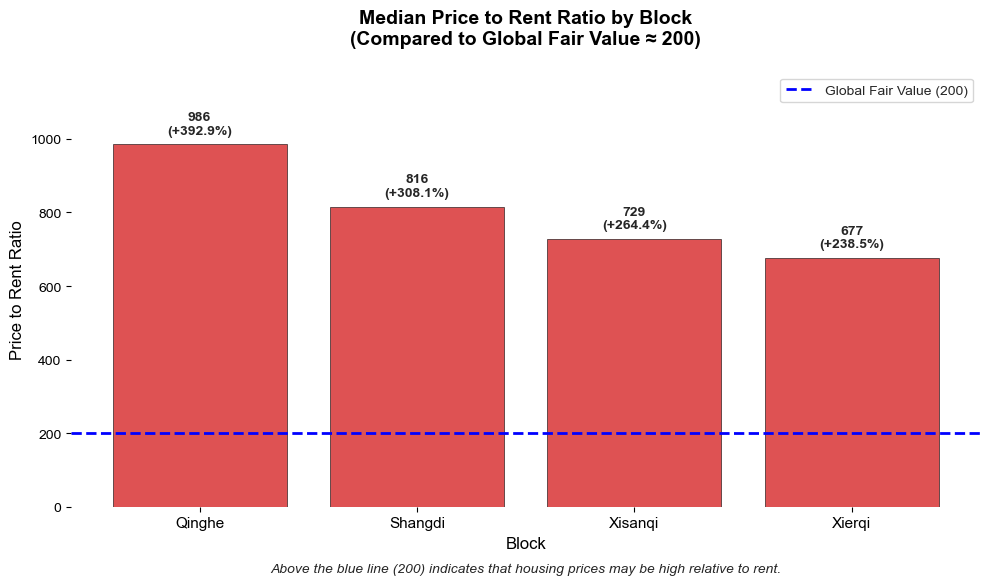

In [32]:
#Bar Plot the median price to rent ratio for each block
global_fair_value = 200

df_ratios = pd.DataFrame({
    'Block': ['Shangdi','Qinghe','Xisanqi','Xierqi'],
    'Median Price to Rent Ratio': price_rent_ratio_by_block.values
})
df_ratios = df_ratios.sort_values('Median Price to Rent Ratio', ascending=False)
fig, ax = plt.subplots(figsize=(10, 6))

# Use seaborn style
sns.set_style("whitegrid")

# Create a bar chart using different colors based on whether it is above the fair value.
colors = ['#d62728' if ratio > global_fair_value else '#2ca02c' 
          for ratio in df_ratios['Median Price to Rent Ratio']]

bars = ax.bar(df_ratios['Block'], df_ratios['Median Price to Rent Ratio'], 
              color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

# Add global fair value reference line
ax.axhline(y=global_fair_value, color='blue', linestyle='--', linewidth=2, 
           label=f'Global Fair Value ({global_fair_value})')

# Add numeric labels
for i, (block, ratio) in enumerate(zip(df_ratios['Block'], df_ratios['Median Price to Rent Ratio'])):
    # Percentage difference from fair value
    diff_percent = ((ratio - global_fair_value) / global_fair_value) * 100
    
    # Add numeric labels
    ax.text(i, ratio + max(df_ratios['Median Price to Rent Ratio']) * 0.02, 
            f'{ratio:.0f}\n({diff_percent:+.1f}%)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Set title and tags
ax.set_title('Median Price to Rent Ratio by Block\n(Compared to Global Fair Value ≈ 200)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Block', fontsize=12)
ax.set_ylabel('Price to Rent Ratio', fontsize=12)

# Set the Y-axis range
ax.set_ylim(0, max(df_ratios['Median Price to Rent Ratio']) * 1.2)

# add legend
ax.legend(loc='upper right')

# Add explanatory text
ax.text(0.5, -0.15, 
        f"Above the blue line ({global_fair_value}) indicates that housing prices may be high relative to rent.", 
        transform=ax.transAxes, ha='center', fontsize=10, style='italic')

# Beautify the chart
sns.despine(left=True, bottom=True)
plt.xticks(fontsize=11)
plt.tight_layout()

# Show the chart
plt.show()

In [33]:
#save cleaned data for modeling
df_cleaned_esf.to_excel('df_cleaned_esf.xlsx', index=False)
df_cleaned_zu.to_excel('df_cleaned_zu.xlsx', index=False)